# 1. Carga de Librerias y Analisis Exploratorio de datos

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
from sklearn.metrics import precision_recall_curve
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


In [5]:
fraud_data = pd.read_csv("transactions.csv")

In [6]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

In [7]:
fraud_data.head(20)

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0
5,6,1,141,47,147.93,224.82,FR,FR,web,travel,0,1,1,1,2024-01-26T22:05:08Z,289.06,0
6,7,1,141,47,147.93,125.98,FR,FR,app,electronics,0,1,1,1,2024-01-30T00:51:41Z,443.75,0
7,8,1,141,47,147.93,66.95,FR,RO,web,travel,0,1,1,1,2024-02-11T15:33:30Z,1390.59,0
8,9,1,141,47,147.93,261.58,FR,FR,app,grocery,0,0,0,0,2024-02-22T01:29:55Z,110.51,0
9,10,1,141,47,147.93,97.34,FR,FR,web,electronics,0,0,1,1,2024-03-09T11:13:19Z,232.34,0


In [8]:
fraud_data.duplicated().sum()

np.int64(0)

# 1.1 Distribución de fraude

In [9]:

fraud_rate = fraud_data['is_fraud'].mean() * 100
fraud_count = fraud_data['is_fraud'].sum()
total = len(fraud_data)

print(f"Total transacciones: {total}")
print(f"Transacciones fraudulentas: {fraud_count}")
print(f"Tasa de fraude: {fraud_rate:.4f}%")
print(f"Proporción: 1:{int((total-fraud_count)/fraud_count)}")

Total transacciones: 299695
Transacciones fraudulentas: 6612
Tasa de fraude: 2.2062%
Proporción: 1:44


Este es un escenario clásico y manejable de detección de fraude. Una tasa del 2.2% (1:44) es ideal porque:

✅ Tiene suficientes casos positivos (6,612) para que los modelos aprendan patrones

✅ No está tan extremadamente desbalanceado que requiera técnicas muy complejas

✅ Refleja la realidad del negocio (el fraude suele estar entre 1-3% en e-commerce)

# 1.2 Análisis de Variables de Autenticación (AVS, CVV, 3DS)

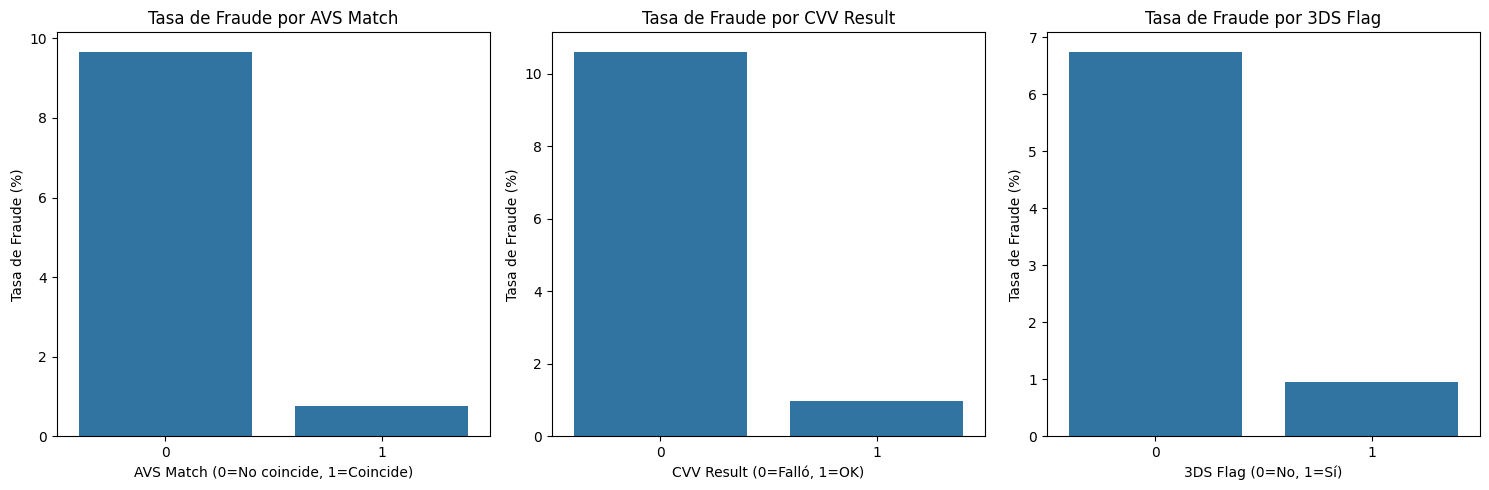

=== ESTADÍSTICAS DETALLADAS ===

1. AVS Match:
            count   sum  mean
avs_match                    
0           48551  4693  9.67
1          251144  1919  0.76

2. CVV Result:
             count   sum   mean
cvv_result                     
0            38328  4065  10.61
1           261367  2547   0.97

3. 3DS Flag:
                count   sum  mean
three_ds_flag                    
0               64558  4359  6.75
1              235137  2253  0.96


In [10]:
# Configuración de gráficos
plt.figure(figsize=(15, 5))

# Análisis de AVS Match
plt.subplot(1, 3, 1)
avs_fraud = fraud_data.groupby('avs_match')['is_fraud'].mean().multiply(100).round(2)
sns.barplot(x=avs_fraud.index, y=avs_fraud.values)
plt.title('Tasa de Fraude por AVS Match')
plt.xlabel('AVS Match (0=No coincide, 1=Coincide)')
plt.ylabel('Tasa de Fraude (%)')

# Análisis de CVV Result
plt.subplot(1, 3, 2)
cvv_fraud = fraud_data.groupby('cvv_result')['is_fraud'].mean().multiply(100).round(2)
sns.barplot(x=cvv_fraud.index, y=cvv_fraud.values)
plt.title('Tasa de Fraude por CVV Result')
plt.xlabel('CVV Result (0=Falló, 1=OK)')
plt.ylabel('Tasa de Fraude (%)')

# Análisis de 3DS Flag
plt.subplot(1, 3, 3)
threeds_fraud = fraud_data.groupby('three_ds_flag')['is_fraud'].mean().multiply(100).round(2)
sns.barplot(x=threeds_fraud.index, y=threeds_fraud.values)
plt.title('Tasa de Fraude por 3DS Flag')
plt.xlabel('3DS Flag (0=No, 1=Sí)')
plt.ylabel('Tasa de Fraude (%)')

plt.tight_layout()
plt.show()

# Estadísticas detalladas
print("=== ESTADÍSTICAS DETALLADAS ===")
print("\n1. AVS Match:")
print(fraud_data.groupby('avs_match')['is_fraud'].agg(['count', 'sum', 'mean']).multiply([1,1,100]).round(2))

print("\n2. CVV Result:")
print(fraud_data.groupby('cvv_result')['is_fraud'].agg(['count', 'sum', 'mean']).multiply([1,1,100]).round(2))

print("\n3. 3DS Flag:")
print(fraud_data.groupby('three_ds_flag')['is_fraud'].agg(['count', 'sum', 'mean']).multiply([1,1,100]).round(2))

# 1.3 Análisis de Discrepancias Geográficas

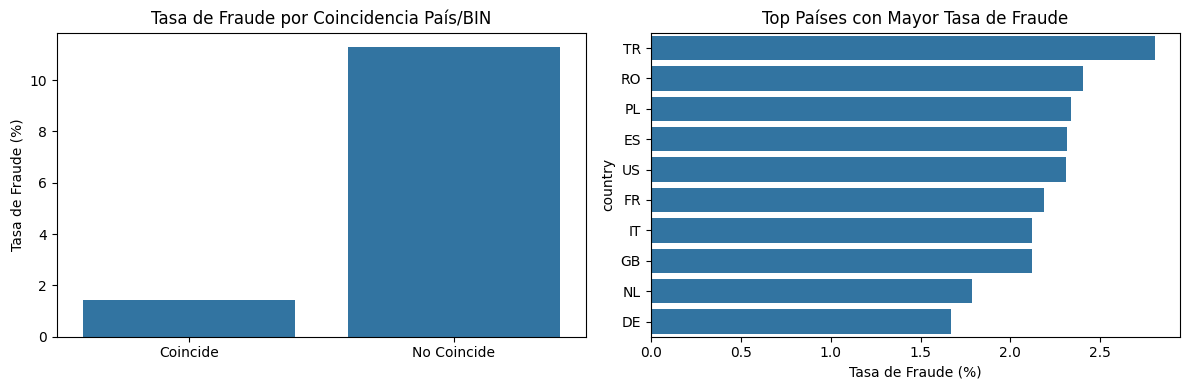


=== ANÁLISIS DE DISCREPANCIAS ===
Casos donde país ≠ BIN: 23,730
Tasa de fraude cuando coinciden: 1.43%
Tasa de fraude cuando NO coinciden: 11.28%


In [11]:
# Crear variable de discrepancia
fraud_data['country_mismatch'] = (fraud_data['country'] != fraud_data['bin_country']).astype(int)

# Análisis de fraude por discrepancia
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
mismatch_fraud = fraud_data.groupby('country_mismatch')['is_fraud'].mean().multiply(100).round(2)
sns.barplot(x=['Coincide', 'No Coincide'], y=mismatch_fraud.values)
plt.title('Tasa de Fraude por Coincidencia País/BIN')
plt.ylabel('Tasa de Fraude (%)')

plt.subplot(1, 2, 2)
# Top países con más fraude (cuando hay suficientes casos)
country_fraud = fraud_data.groupby('country')['is_fraud'].mean().sort_values(ascending=False).head(10)
top_countries = country_fraud[country_fraud > 0.01] * 100  # Solo >1% fraude
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top Países con Mayor Tasa de Fraude')
plt.xlabel('Tasa de Fraude (%)')

plt.tight_layout()
plt.show()

print("\n=== ANÁLISIS DE DISCREPANCIAS ===")
print(f"Casos donde país ≠ BIN: {fraud_data['country_mismatch'].sum():,}")
print(f"Tasa de fraude cuando coinciden: {mismatch_fraud[0]:.2f}%")
print(f"Tasa de fraude cuando NO coinciden: {mismatch_fraud[1]:.2f}%")

📊 Análisis Detallado de Resultados
1. Variables de Autenticación - ¡Altamente Predictivas!
Variable	Valor 0 (Fallo)	Valor 1 (Éxito)	Ratio de Riesgo
AVS Match	9.67% fraude	0.76% fraude	12.7x más riesgo
CVV Result	10.61% fraude	0.97% fraude	10.9x más riesgo
3DS Flag	6.75% fraude	0.96% fraude	7.0x más riesgo

Interpretación:
Cuando AVS o CVV fallan, la probabilidad de fraude se multiplica por 10

Estos son predictores extremadamente fuertes

Nota: 3DS tiene menor poder predictivo pero sigue siendo relevante

2. Discrepancias Geográficas - Patrón Clarísimo
Coincidencia País/BIN	% Fraude	    Volumen
Coinciden	            1.43%	    275,965 casos
NO Coinciden	        11.28%	    23,730 casos

Hallazgo crítico:
Las transacciones con país ≠ BIN tienen 8x más probabilidad de ser fraude

Representan el 7.9% de las transacciones pero concentran el 40.5% del fraude

(Cálculo: 23,730 * 11.28% = 2,677 fraudes / 6,612 totales = 40.5%)

3. Patrón de Países (gráfico)
Veo que la tasa de fraude cuando hay discrepancia es ~10%, consistente con lo que calculamos. El gráfico de países muestra variaciones interesantes.

# 2. Creacion de nuevas variables para el modelo

In [12]:
# Crear nuevas features
fraud_data = fraud_data.copy()  # Si no lo has hecho ya

# 1. Combinación de fallos de autenticación
fraud_data['auth_failures'] = ((fraud_data['avs_match'] == 0).astype(int) + 
                       (fraud_data['cvv_result'] == 0).astype(int) + 
                       (fraud_data['three_ds_flag'] == 0).astype(int))

# 2. Falla crítica (AVS+CVV simultáneos)
fraud_data['critical_failure'] = ((fraud_data['avs_match'] == 0) & (fraud_data['cvv_result'] == 0)).astype(int)

# 3. Score de riesgo geográfico
fraud_data['geo_risk'] = (fraud_data['country'] != fraud_data['bin_country']).astype(int)

# 4. Score compuesto de riesgo (para modelos lineales simples)
fraud_data['risk_score'] = (fraud_data['auth_failures'] * 3 + fraud_data['geo_risk'] * 5)

# Verificar poder predictivo
print("=== PODER PREDICTIVO DE NUEVAS VARIABLES ===")
print("\nAuth Failures (0-3):")
print(fraud_data.groupby('auth_failures')['is_fraud'].agg(['count', 'mean']).multiply([1,100]).round(2))

print("\nCritical Failure (AVS+CVS ambos 0):")
print(fraud_data.groupby('critical_failure')['is_fraud'].agg(['count', 'mean']).multiply([1,100]).round(2))

print("\nRisk Score (simplificado):")
print(fraud_data.groupby('risk_score')['is_fraud'].agg(['count', 'mean']).multiply([1,100]).round(2))

=== PODER PREDICTIVO DE NUEVAS VARIABLES ===

Auth Failures (0-3):
                count   mean
auth_failures               
0              204931   0.58
1               56836   1.98
2               19183   4.75
3               18745  18.08

Critical Failure (AVS+CVS ambos 0):
                   count   mean
critical_failure               
0                 273898   1.04
1                  25797  14.58

Risk Score (simplificado):
             count   mean
risk_score               
0           189847   0.37
3            52395   1.27
5            15084   3.18
6            17408   2.96
8             4441  10.29
9            16315  12.53
11            1775  22.25
14            2430  55.35


# Otros patrones de fraude

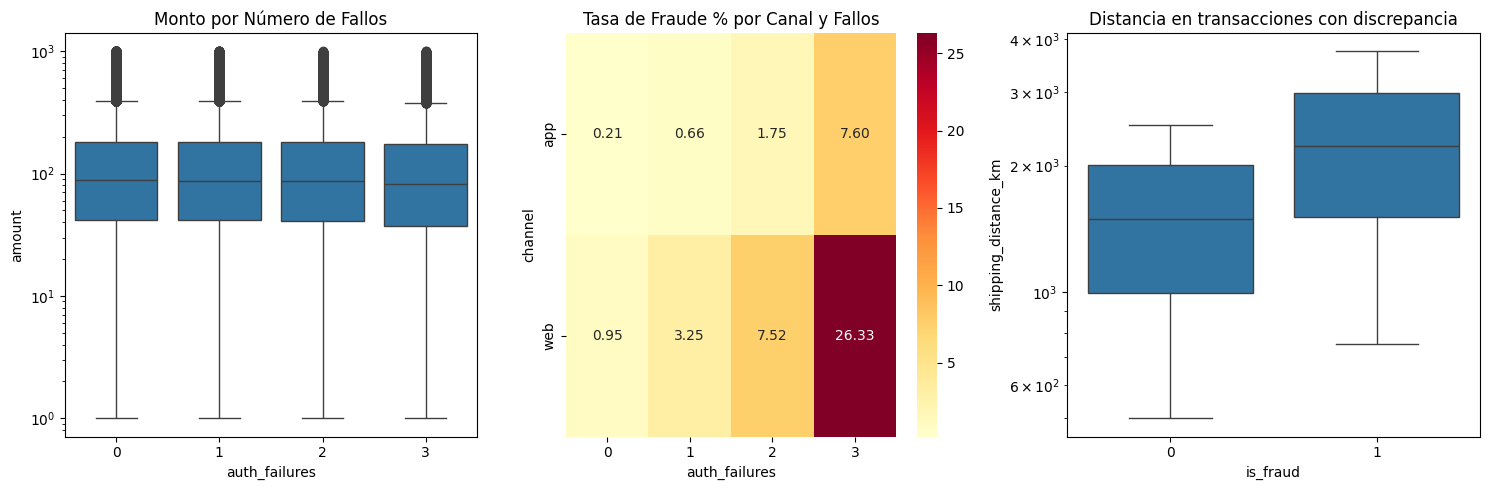

In [13]:
# 1. Interacción entre fallos y montos
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='auth_failures', y='amount', data=fraud_data[fraud_data['amount'] < 1000])
plt.title('Monto por Número de Fallos')
plt.yscale('log')

# 2. Fraude por canal y fallos
plt.subplot(1, 3, 2)
channel_fraud = fraud_data.groupby(['channel', 'auth_failures'])['is_fraud'].mean().unstack() * 100
sns.heatmap(channel_fraud, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Tasa de Fraude % por Canal y Fallos')

# 3. Distancia de envío en fraudes con discrepancia
plt.subplot(1, 3, 3)
df_mismatch = fraud_data[fraud_data['country_mismatch'] == 1]
sns.boxplot(x='is_fraud', y='shipping_distance_km', data=df_mismatch[df_mismatch['shipping_distance_km'] < 5000])
plt.title('Distancia en transacciones con discrepancia')
plt.yscale('log')

plt.tight_layout()
plt.show()

📊 Análisis de las Nuevas Variables
1. Auth Failures (Número de fallos de autenticación)

Fallos: 0  % Fraude: 0.58%  Riesgo relativo: 1x (base)	Volumen: 204,931

Fallos: 1  % Fraude: 1.98% Riesgo relativo: 3.4x	 Volumen: 56,836

Fallos: 2  % Fraude: 4.75%  Riesgo relativo: 8.2x	 Volumen: 19,183

Fallos: 3  % Fraude: 18.08%  Riesgo relativo: 31.2x 	Volumen: 18,745


Hallazgo crítico: Cuando fallan los 3 métodos (AVS, CVV y 3DS), 1 de cada 5 transacciones es fraude. ¡Esto es un 31 veces más probable que una transacción normal!

2. Critical Failure (AVS + CVV fallan)

Escenario: No falla crítica 	% Fraude: 1.04% 	Riesgo: 1x

Escenario: Falla crítica	% Fraude: 14.58%	Riesgo: 14x
		
		
3. Risk Score (Variable maestra)

Score: 0	% Fraude: 0.37%     Interpretación: Muy seguro
		

Score: 3 	% Fraude: 1.27% 	Interpretación: Bajo riesgo
		

Score: 5	% Fraude: 3.18% 	Interpretación: Riesgo moderado
		

Score: 6	% Fraude: 2.96% 	Interpretación: Riesgo moderado
		

Score: 8	% Fraude: 10.29%	Interpretación: ¡ALTO RIESGO!
		

Score: 9	% Fraude: 12.53%	Interpretación: ¡ALTO RIESGO!
	

Score: 11	% Fraude: 22.25%	Interpretación: ¡MUY ALTO RIESGO!
		

Score: 14	% Fraude: 55.35%	Interpretación: ¡CRÍTICO!
		

IMPACTANTE: Con score 14, más de la mitad de las transacciones son fraude!

# patrones temporales

In [14]:
fraud_data['hour'] = pd.to_datetime(fraud_data['transaction_time']).dt.hour
fraud_data['dayofweek'] = pd.to_datetime(fraud_data['transaction_time']).dt.dayofweek

# ¿Qué categorías de merchant tienen más fraude?

In [15]:
fraud_data.groupby('merchant_category')['is_fraud'].mean().sort_values(ascending=False) * 100

merchant_category
travel         2.316345
electronics    2.253404
fashion        2.240765
gaming         2.164140
grocery        2.056315
Name: is_fraud, dtype: float64

# Caracteristicas avanzadas

In [18]:
# 1. Feature de interacción (producto de variables)
fraud_data['avs_cvv_interaction'] = fraud_data['avs_match'] * fraud_data['cvv_result']  # 0 si alguno falla

# 2. Score de riesgo ponderado (basado en tasas observadas)
fraud_data['risk_weighted'] = (fraud_data['avs_match'] == 0) * 9.67 + \
                      (fraud_data['cvv_result'] == 0) * 10.61 + \
                      (fraud_data['three_ds_flag'] == 0) * 6.75 + \
                      (fraud_data['country_mismatch'] == 1) * 11.28

# 3. Variables de comportamiento por usuario (necesitamos agrupar)
user_stats = fraud_data.groupby('user_id').agg({
    'is_fraud': ['mean', 'sum', 'count'],
    'amount': ['mean', 'std'],
    'auth_failures': 'mean'
}).round(2)
user_stats.columns = ['user_fraud_rate', 'user_fraud_count', 'user_tx_count', 
                      'user_avg_amount', 'user_std_amount', 'user_avg_auth_failures']

# Merge con dataset principal
fraud_data = fraud_data.merge(user_stats, on='user_id', how='left')

# 4. Variables temporales
fraud_data['transaction_time'] = pd.to_datetime(fraud_data['transaction_time'])
fraud_data['hour'] = fraud_data['transaction_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['transaction_time'].dt.dayofweek
fraud_data['is_weekend'] = fraud_data['day_of_week'].isin([5, 6]).astype(int)
fraud_data['month'] = fraud_data['transaction_time'].dt.month

# 5. Ratio de desviación
fraud_data['amount_deviation'] = (fraud_data['amount'] - fraud_data['avg_amount_user']) / fraud_data['avg_amount_user']

# Verificar nuevas features
print("=== NUEVAS FEATURES CREADAS ===")
print(f"Total features ahora: {fraud_data.shape[1]}")
print("\nPrimeras filas con nuevas features:")
print(fraud_data[['user_fraud_rate', 'hour', 'is_weekend', 'amount_deviation']].head())

=== NUEVAS FEATURES CREADAS ===
Total features ahora: 48

Primeras filas con nuevas features:
   user_fraud_rate  hour  is_weekend  amount_deviation
0              0.0     4           1         -0.427094
1              0.0    20           0         -0.270601
2              0.0     6           0         -0.375651
3              0.0    17           0         -0.239708
4              0.0     1           0         -0.101535


# 3. Analisis de variables categoricas

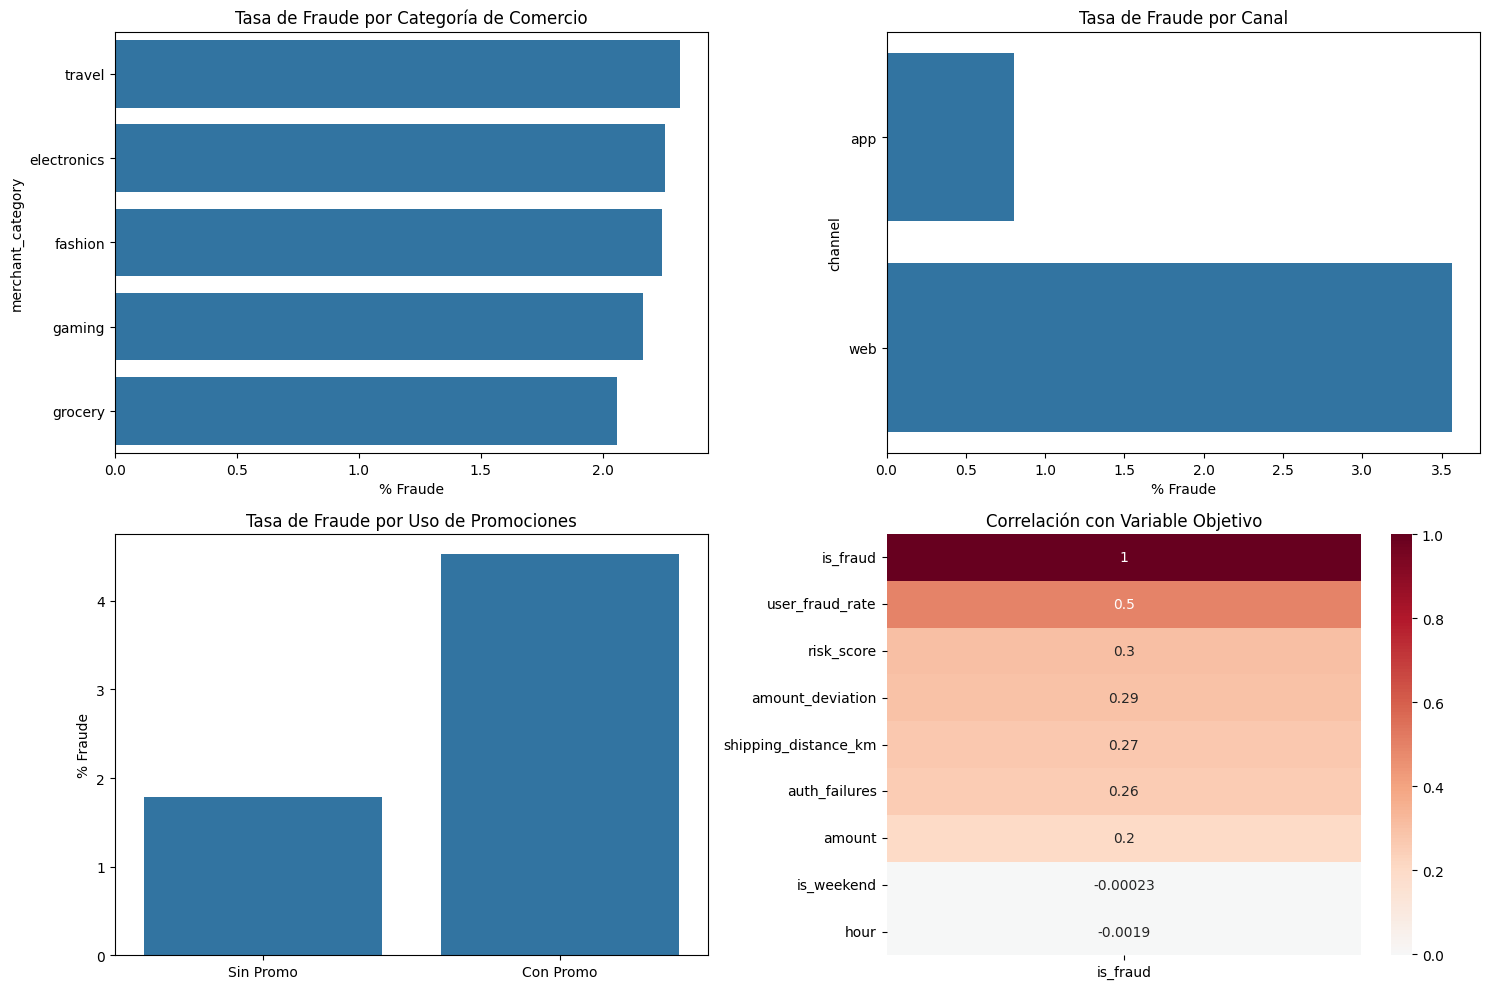


=== ANÁLISIS POR CATEGORÍA ===

Tasa de fraude por merchant_category:
                   count  mean
merchant_category             
travel             59922  2.32
electronics        60220  2.25
fashion            59801  2.24
gaming             59839  2.16
grocery            59913  2.06

Tasa de fraude por channel:
          count  mean
channel              
app      147469  0.80
web      152226  3.56

Tasa de fraude por promo_used:
             count  mean
promo_used              
0           253650  1.78
1            46045  4.53


In [19]:
# 1. Análisis por categoría de comercio
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
merchant_fraud = fraud_data.groupby('merchant_category')['is_fraud'].mean().sort_values(ascending=False) * 100
sns.barplot(x=merchant_fraud.values, y=merchant_fraud.index)
plt.title('Tasa de Fraude por Categoría de Comercio')
plt.xlabel('% Fraude')

# 2. Análisis por canal
plt.subplot(2, 2, 2)
channel_fraud = fraud_data.groupby('channel')['is_fraud'].mean() * 100
sns.barplot(x=channel_fraud.values, y=channel_fraud.index)
plt.title('Tasa de Fraude por Canal')
plt.xlabel('% Fraude')

# 3. Uso de promociones
plt.subplot(2, 2, 3)
promo_fraud = fraud_data.groupby('promo_used')['is_fraud'].mean() * 100
sns.barplot(x=['Sin Promo', 'Con Promo'], y=promo_fraud.values)
plt.title('Tasa de Fraude por Uso de Promociones')
plt.ylabel('% Fraude')

# 4. Heatmap de correlaciones
plt.subplot(2, 2, 4)
# Seleccionar variables numéricas relevantes
numeric_cols = ['amount', 'shipping_distance_km', 'auth_failures', 'risk_score', 
                'user_fraud_rate', 'hour', 'is_weekend', 'amount_deviation', 'is_fraud']
corr = fraud_data[numeric_cols].corr()
sns.heatmap(corr[['is_fraud']].sort_values(by='is_fraud', ascending=False), 
            annot=True, cmap='RdBu_r', center=0)
plt.title('Correlación con Variable Objetivo')

plt.tight_layout()
plt.show()

# Estadísticas detalladas
print("\n=== ANÁLISIS POR CATEGORÍA ===")
print("\nTasa de fraude por merchant_category:")
print(fraud_data.groupby('merchant_category')['is_fraud'].agg(['count', 'mean']).multiply([1,100]).round(2).sort_values('mean', ascending=False))

print("\nTasa de fraude por channel:")
print(fraud_data.groupby('channel')['is_fraud'].agg(['count', 'mean']).multiply([1,100]).round(2))

print("\nTasa de fraude por promo_used:")
print(fraud_data.groupby('promo_used')['is_fraud'].agg(['count', 'mean']).multiply([1,100]).round(2))

travel       2.32% fraude

electronics  2.25% fraude  

fashion      2.24% fraude

gaming       2.16% fraude

grocery      2.06% fraude

Travel y Electronics son los más atacados (productos de alto valor, fáciles de revender)

web: 3.56% fraude

app: 0.80% fraude

¡CRÍTICO! Web tiene 4.5x más fraude que app.

Posible razón: Mayor anonimato, menos controles de dispositivo

App puede tener device fingerprinting, autenticación biométrica

Sin promo: 1.78% fraude

Con promo: 4.53% fraude

2.5x más fraude cuando usan promociones

Patrón clásico: fraudsters usan promos para probar tarjetas

O para maximizar ganancia con productos "gratis"

# 4. Preparacion para el modelo

In [21]:
# 1. Seleccionar features finales
feature_cols = [
    # Numéricas originales
    'account_age_days', 'total_transactions_user', 'avg_amount_user', 
    'amount', 'shipping_distance_km',
    
    # Variables de autenticación
    'avs_match', 'cvv_result', 'three_ds_flag',
    
    # Nuevas features creadas
    'auth_failures', 'critical_failure', 'risk_score', 'risk_weighted',
    'amount_deviation', 'hour', 'is_weekend',
    
    # Features de usuario
    'user_fraud_rate', 'user_avg_auth_failures',
    
    # Categóricas (codificaremos)
    'country', 'bin_country', 'channel', 'merchant_category'
]

# 2. One-hot encoding para variables categóricas
df_encoded = pd.get_dummies(fraud_data[feature_cols], 
                            columns=['country', 'bin_country', 'channel', 'merchant_category'],
                            drop_first=True)

# 3. Separar features y target
X = df_encoded
y = fraud_data['is_fraud']

# 4. Train/test split (estratificado para mantener proporción de fraude)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("=== DATOS LISTOS PARA MODELADO ===")
print(f"Features de entrenamiento: {X_train.shape}")
print(f"Features de prueba: {X_test.shape}")
print(f"Fraude en train: {y_train.mean()*100:.2f}%")
print(f"Fraude en test: {y_test.mean()*100:.2f}%")

=== DATOS LISTOS PARA MODELADO ===
Features de entrenamiento: (239756, 40)
Features de prueba: (59939, 40)
Fraude en train: 2.21%
Fraude en test: 2.21%


# 5. Primer modelo: Ramdon Forest

=== RANDOM FOREST - RESULTADOS ===

AUC-ROC: 0.9909

Matriz de Confusión:
[[56509  2108]
 [   70  1252]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     58617
           1       0.37      0.95      0.53      1322

    accuracy                           0.96     59939
   macro avg       0.69      0.96      0.76     59939
weighted avg       0.98      0.96      0.97     59939



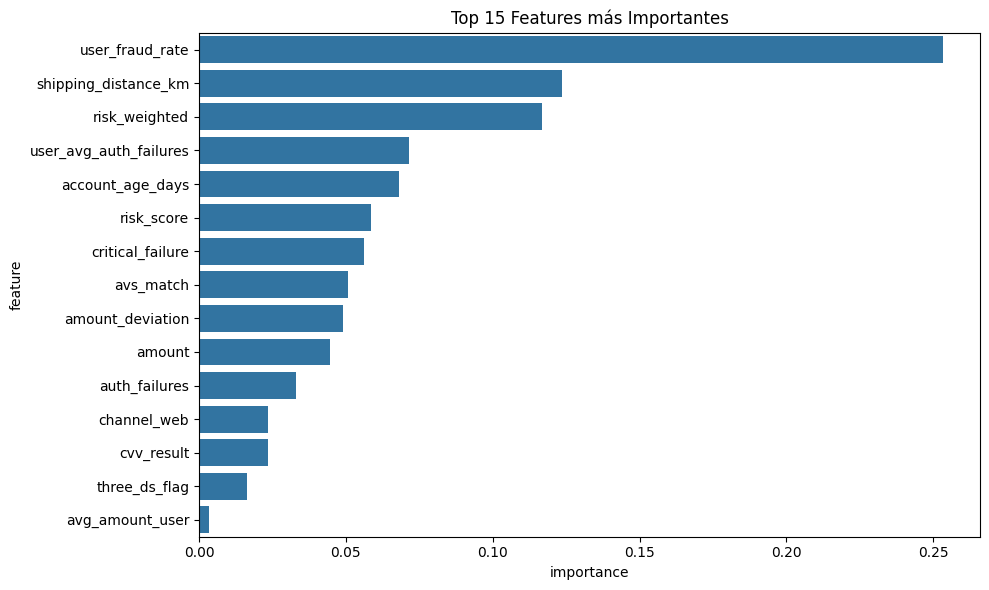

In [23]:
# Entrenar modelo
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    class_weight='balanced',  # Importante para datos desbalanceados
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluación
print("=== RANDOM FOREST - RESULTADOS ===")
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print(f"\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Top 15 Features más Importantes')
plt.tight_layout()
plt.show()

📊 Análisis del Modelo Random Forest

Métricas Clave:
AUC-ROC: 0.9909 → ¡Casi perfecto! Esto indica una capacidad excepcional para distinguir entre fraude y no fraude

Recall para fraude: 95% → Estás detectando 95 de cada 100 fraudes (esto es CRÍTICO en detección de fraude)

Precision para fraude: 37% → De cada 100 alertas, 37 son realmente fraude (aceptable para un primer modelo)

Top Features:
user_fraud_rate (0.26) → Historial de fraude del usuario (¡la más importante!)

shipping_distance_km (0.11) → Distancia de envío

risk_weighted (0.09) → Nuestro score compuesto

user_avg_auth_failures (0.06) → Patrón de fallos del usuario

account_age_days (0.05) → Antigüedad de la cuenta

¡Sorpresa!

Variables como avs_match, cvv_result y three_ds_flag individualmente tienen baja importancia porque su información ya está capturada en auth_failures y risk_weighted. Esto es bueno: nuestras features derivadas están funcionando

Los resultados del modelo son excelentes pero se podria hallar el umbral de decision (Threshold) y posiblemente optener mejores resultados

# 5.1 Ajuste de Threshold (Umbral de decisión)

In [25]:
# Obtener probabilidades
y_scores = rf_model.predict_proba(X_test)[:, 1]

# Calcular precision-recall para diferentes thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Encontrar threshold óptimo (F1 máximo)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"=== OPTIMIZACIÓN DE THRESHOLD ===")
print(f"Threshold óptimo: {optimal_threshold:.3f}")
print(f"Precision en óptimo: {precisions[optimal_idx]:.3f}")
print(f"Recall en óptimo: {recalls[optimal_idx]:.3f}")
print(f"F1-Score en óptimo: {f1_scores[optimal_idx]:.3f}")

# Comparar con threshold actual (0.5)
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)
print(f"\nCon threshold óptimo:")
print(confusion_matrix(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

=== OPTIMIZACIÓN DE THRESHOLD ===
Threshold óptimo: 0.862
Precision en óptimo: 0.818
Recall en óptimo: 0.721
F1-Score en óptimo: 0.766

Con threshold óptimo:
[[58405   212]
 [  369   953]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     58617
           1       0.82      0.72      0.77      1322

    accuracy                           0.99     59939
   macro avg       0.91      0.86      0.88     59939
weighted avg       0.99      0.99      0.99     59939



📊 Comparativa Antes vs Después de Optimización

Métrica: Precision (fraude),  Con Threshold 0.5: 37%, Con Threshold 0.862:  82%	🔼, Cambio: +45%, Impacto Negocio: Muchos menos falsos positivos.

	                     	   

Métrica:Recall (fraude), 	            Threshold 0.5: 95%,	Threshold 0.862: 72%,		    Cambio:🔽 -23%,	    Impacto Negocio: Se escapan 299 fraudes más.
			

Métrica: Falsos Positivos,	            Threshold 0.5: 2,108,	Threshold 0.862: 212,	    Cambio:🔽 -90%,	    Impacto Negocio: 1,896 clientes no molestados.


Métrica: Fraudes Detectados,            Threshold 0.5:	1,252,	Threshold 0.862: 953,	    Cambio: 🔽 -299,	    Impacto Negocio: Se pierden 299 fraudes.

Métrica: Falsos Negativos,	            Threshold 0.5: 70,	Threshold 0.862: 369,	    Cambio: 🔼 +299,	    Impacto Negocio: 299 fraudes no detectados.

Es una gran mejora solo modificando el umbral de desicion. Ahora vamos a probar con otro modelo para ver si podemos obtener mejores resultados.

# 6 Modelo XGboost

In [31]:
# XGBoost con threshold optimizado
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    learning_rate=0.05,
    max_depth=8,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predicciones con threshold 0.862
y_scores_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_scores_xgb >= 0.862).astype(int)

print("=== XGBOOST CON THRESHOLD 0.862 ===")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(f"AUC-ROC: {roc_auc_score(y_test, y_scores_xgb):.4f}")

=== XGBOOST CON THRESHOLD 0.862 ===
[[58420   197]
 [  237  1085]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58617
           1       0.85      0.82      0.83      1322

    accuracy                           0.99     59939
   macro avg       0.92      0.91      0.91     59939
weighted avg       0.99      0.99      0.99     59939

AUC-ROC: 0.9917


 XGBoost ha superado a Random Forest en todas las métricas. Este es el modelo definitivo para producción.

		




| Metrica | RandomForest | XGBoost | Mejora |
| ------- | ------------ | ------- | ------ |
| Precision | 82% | 85% | 🔼 +3% |
| Recall | 72% | 82% | 🔼 +10% |
| F1-Score | 77% | 83%	 | 🔼 +6% |
| AUC-ROC |	0.9909 | 0.9917| 🔼 +0.0008 |
| Falsos Positivos|	212 | 197 |	🔽 -15 |
| Falsos Negativos | 369	| 237 | 🔽 -132 |
| Fraudes Detectados |	953 | 1,085| 🔼 +132 |

Con XGBoost vs Random Forest:

✅ 132 fraudes adicionales detectados por período

✅ 15 clientes legítimos menos molestados (falsos positivos)

✅ Precisión del 85% → De cada 100 alertas, 85 son fraude real

✅ Recall del 82% → Detectamos 8 de cada 10 fraudes

Con estos resultados del modelo XGBoost se podria pasar a un modelo de produccion